# Perturbation Space

pertpy delineates between two fundamental domains to embed and analyze data: the "cell space" and the "perturbation space".
In this paradigm, the cell space encapsulates configurations where discrete data points inherently represent individual cells. A prevalent manifestation of this pattern can be observed through prominent visualization techniques such as UMAP embeddings as commonly observed in publications.
Conversely, the perturbation space departs from the individualistic perspective of cells and instead organizes cells into cohesive ensembles that have undergone similar perturbations. These grouped cells are subsequently embedded to faithfully encapsulate the nature of the perturbation itself.
This specialized space enables comprehending the collective impact of perturbations on cells.

pertpy offers [several distinct ways](https://pertpy.readthedocs.io/en/latest/usage/usage.html#perturbation-space) of determining the perturbation space that will be introduced in this tutorial. We differentiate between perturbation spaces (where we create one datapoint for all cells of one perturbation) and cluster spaces (where we cluster all cells and then test how well the clustering overlaps with the perturbations). In this tutorial, we will introduce several methods for obtaining data embeddings in both the perturbation space and the cluster space.

We will be working with the pre-processed Norman dataset (counts are already normalized), which encompases a pooled CRISPR screening experiment comparing the transcriptional effects of overexpressing genes alone or in combination.

Reference: Norman, Thomas M et al. “Exploring genetic interaction manifolds constructed from rich single-cell phenotypes.” Science (New York, N.Y.) vol. 365,6455 (2019): 786-793. doi:10.1126/science.aax4438

## Setup

In [1]:
import os
os.environ['KMP_WARNINGS'] = 'off'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pertpy as pt
import scanpy as sc

In [3]:
adata = pt.dt.norman_2019()
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [5]:
adata.obs.head()

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,4108,4108,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,3142,3142,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,4229,4229,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,2114,2114,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,2753,2753,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN


The Norman dataset has annotations for gene programmes for many perturbations, which we will use later to evaluate the perturbation spaces. These gene programmes can be obtained from the [Norman paper](https://www.science.org/doi/10.1126/science.aax4438):

In [6]:
G1_CYCLE = [
    'CDKN1A', {'CDKN1B', 'CDKN1A'}, 'CDKN1B', {'CDKN1C', 'CDKN1A'}, {'CDKN1C', 'CDKN1B'}, 'CDKN1C'
]

ERYTHROID = [
    {'CBL', 'CNN1'}, {'CBL', 'PTPN12'}, {'CBL', 'PTPN9'}, {'CBL', 'UBASH3B'}, {'SAMD1', 'PTPN12'},
    {'SAMD1', 'UBASH3B'}, {'UBASH3B', 'CNN1'}, {'UBASH3B', 'PTPN12'}, {'UBASH3B', 'PTPN9'}, {'UBASH3B', 'UBASH3A'},
    {'UBASH3B', 'ZBTB25'}, {'BPGM', 'SAMD1'}, 'PTPN1', {'PTPN12', 'PTPN9'}, {'PTPN12', 'UBASH3A'}, {'PTPN12', 'ZBTB25'},
    {'UBASH3A', 'CNN1'}
]

PIONEER_FACTORS = [
    {'FOXA1', 'FOXF1'}, {'FOXA1', 'FOXL2'}, {'FOXA1', 'HOXB9'}, {'FOXA3', 'FOXA1'}, {'FOXA3', 'FOXF1'},
    {'FOXA3', 'FOXL2'}, {'FOXA3', 'HOXB9'}, 'FOXA3', {'FOXF1', 'FOXL2'}, {'FOXF1', 'HOXB9'}, {'FOXL2', 'MEIS1'},
    'HOXA13',
    'HOXC13', {'POU3F2', 'FOXL2'}, 'TP73', 'MIDN', {'LYL1', 'IER5L'}, 'HOXC13', {'DUSP9', 'SNAI1'}, {'ZBTB10', 'SNAI1'}
]

GRANULOCYTE_APOPTOSIS = [
    'SPI1', 'CEBPA', {'CEBPB', 'CEBPA'}, 'CEBPB', {'CEBPE', 'CEBPA'}, {'CEBPE', 'CEBPB'}, {'CEBPE', 'RUNX1T1'},
    {'CEBPE', 'SPI1'}, 'CEBPE', {'ETS2', 'CEBPE'}, {'KLF1', 'CEBPA'}, {'FOSB', 'CEBPB'}, {'FOSB', 'CEBPE'},
    {'ZC3HAV1', 'CEBPA'}, {'JUN', 'CEBPA'}
]

PRO_GROWTH = [
    {'CEBPE', 'KLF1'}, 'KLF1', {'KLF1', 'BAK1'}, {'KLF1', 'MAP2K6'}, {'KLF1', 'TGFBR2'}, 'ELMSAN1',
    {'MAP2K3', 'SLC38A2'}, {'MAP2K3', 'ELMSAN1'}, 'MAP2K3', {'MAP2K3', 'MAP2K6'}, {'MAP2K6', 'ELMSAN1'}, 'MAP2K6',
    {'MAP2K6', 'KLF1'}
]

MEGAKARYOCYTE = [
    {'MAPK1', 'TGFBR2'}, 'MAPK1', {'ETS2', 'MAPK1'}, 'ETS2', {'CEBPB', 'MAPK1'}
]

programmes = {
    'G1 cell cycle': G1_CYCLE,
    'Erythroid': ERYTHROID,
    'Pioneer factors': PIONEER_FACTORS,
    'Granulocyte apoptosis': GRANULOCYTE_APOPTOSIS,
    'Pro-growth': PRO_GROWTH,
    'Megakaryocyte': MEGAKARYOCYTE
}

Now we will save the gene programmes in our AnnData object as an additional '.obs' columns:

In [7]:
gene_programme = []

for target_pert in adata.obs['perturbation_name']:
    if target_pert == 'control':
        gene_programme.append('Control')
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split('+'))) or (target_pert == pert):
                gene_programme.append(programme)
                found_programme = True
                break
                
    if not found_programme:
        gene_programme.append('Unknown')

adata.obs['gene_programme'] = gene_programme

We will work only with the perturbations that have a defined gene programme, since we want to evaluate the perturbation spaces afterward.

In [8]:
adata = adata[adata.obs['gene_programme'] != 'Unknown']

## Embed data in Perturbation Spaces

When embedding data in the perturbation space, we aim to generate on datapoint from all cells of one perturbation. In this tutorial, we introduce three different ways to do so:

- Pseudobulk Space
- Discriminator Classifier
- Centroid Space

### Pseudobulk Space

The Pseudobulk space returns an Anndata object in which each observation corresponds to the pseudobulk expression of all cells of the respective perturbation.

In [9]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(adata, target_col="perturbation_name", groups_col="perturbation_name", mode="mean", min_cells=0,
                     min_counts=0)

In [10]:
psadata

AnnData object with n_obs × n_vars = 75 × 19017
    obs: 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guide_KLF1', 'guide_KMT2A', 'guide_LHX1', 'guide_LYL1', 'guide_MAML2', 'guide_MAP2K3', 'guide_MAP2K6', 'guide

In [11]:
psadata.obs.head()

,guide_AHR,guide_ARID1A,guide_ARRDC3,guide_ATL1,guide_BAK1,guide_BCL2L11,guide_BCORL1,guide_BPGM,guide_C19orf26,guide_C3orf72,...,guide_ZC3HAV1,guide_ZNF318,guide_ids,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_programme,psbulk_n_cells,psbulk_counts
BAK1+KLF1,0,0,0,0,1,0,0,0,0,0,...,0,0,"BAK1,KLF1",BAK1+KLF1,genetic,NaN,NaN,Pro-growth,392.0,1.186428e+06
BPGM+SAMD1,0,0,0,0,0,0,0,1,0,0,...,0,0,"BPGM,SAMD1",BPGM+SAMD1,genetic,NaN,NaN,Erythroid,300.0,8.491724e+05
CBL+CNN1,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,CNN1",CBL+CNN1,genetic,NaN,NaN,Erythroid,348.0,9.622422e+05
CBL+PTPN12,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,PTPN12",CBL+PTPN12,genetic,NaN,NaN,Erythroid,333.0,9.529553e+05
CBL+PTPN9,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,PTPN9",CBL+PTPN9,genetic,NaN,NaN,Erythroid,305.0,8.501961e+05


In the generated AnnData object, each observation represents a perturbation, and its expression is the `mode` of the PseudobulkSpace function.

Now, the perturbation space can be visualized, and various operations can be applied to analyze it.

         Falling back to preprocessing with `sc.pp.pca` and default params.


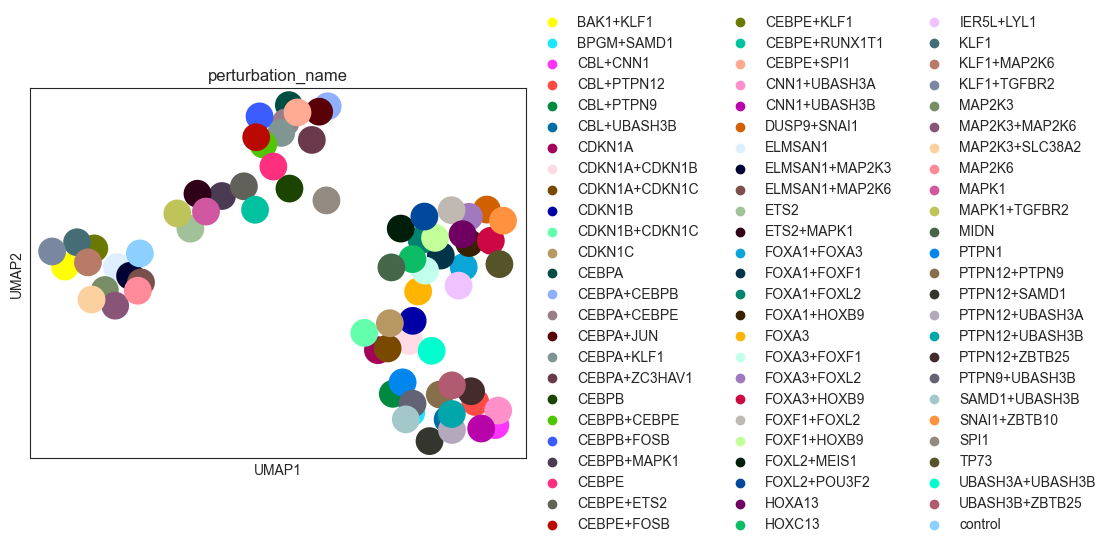

In [13]:
sc.pp.neighbors(psadata)
sc.tl.umap(psadata)
sc.pl.umap(psadata, color='perturbation_name')

Based on the UMAP visualization of the perturbation space above, we see that the individual perturbations are grouped into clusters. Next, we want to check if the clusters correspond to the gene programmes that we have defined for the individual perturbations above.

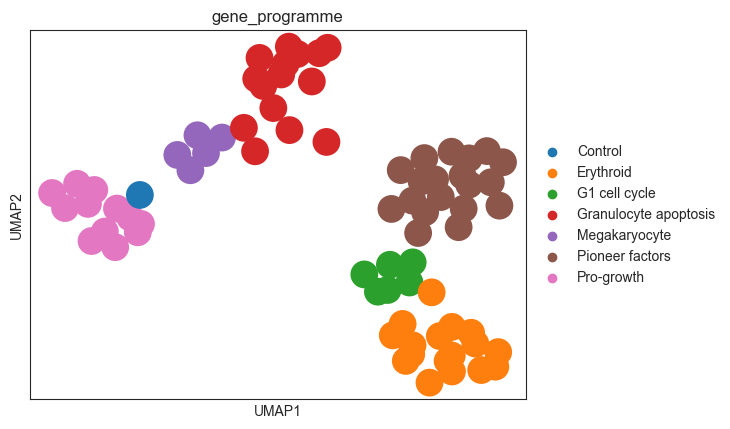

In [14]:
sc.pl.umap(psadata, color='gene_programme')

When coloring the individual perturbations according to their gene programs, we observe that the clusters align with the gene programs. This indicates that the perturbation space nicely captures the effects of the perturbations on the cells. Furthermore, when looking at the control perturbation (in the UMAP plot above depicted in blue), we see that it is situated on the periphery of the 'pro-growth' cluster, suggesting that the perturbations in this cluster might have only a small effect on the cells.

Another option is to calculate the difference between the perturbations and the control, using the `compute_control_diff` method. Afterward, we can again calculate and visualize the perturbation space:

In [15]:
sc.pp.neighbors(adata)
sc.tl.pca(adata)

In [16]:
diff_adata = ps.compute_control_diff(adata, target_col='perturbation_name', reference_key='control', embedding_key='X_pca')

In [17]:
diff_psadata = ps.compute(diff_adata, target_col="perturbation_name", groups_col="perturbation_name", mode="mean", min_cells=0, min_counts=0, embedding_key='X_pca', skip_checks=True)

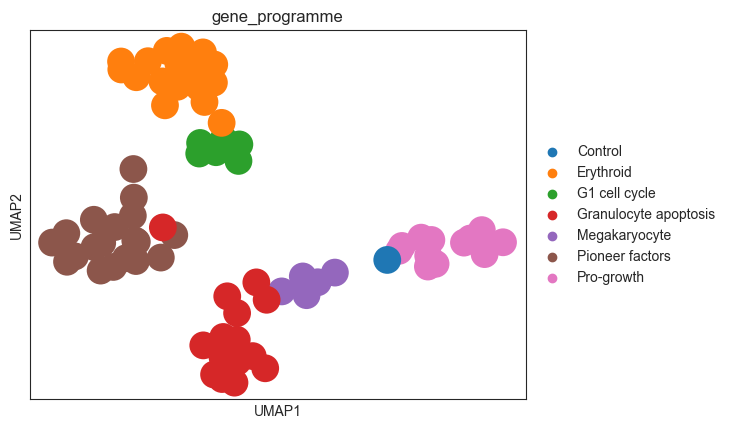

In [18]:
sc.pp.neighbors(diff_psadata)
sc.tl.umap(diff_psadata)
sc.pl.umap(diff_psadata, color='gene_programme')

As the individual perturbations already clustered nicely before the control difference was calculated, we do not see a big difference in the UMAP plot in terms of the clustering. We can see that the perturbations with the same gene programme cluster even a bit more densely than before. We also note one "Granulocyte apoptosis" perturbation that is situated in the "Pioneer factors" cluster, which could be worth investigating further.

### Discriminator Classifier

The Discriminator Classifier embedding method trains a NN classifier to predict which perturbation has been applied to each cell. Once the training has finished, we obtain the representations of the last layer as embedding of the perturbations.

In [9]:
ps = pt.tl.DiscriminatorClassifierSpace()

The `load` method creates the model to train and the dataloaders. It accepts different hyperparameters related with the architecture of the model such as `hidden_dim`, `dropout`, `batch_norm`, etc. 
Training hyperparameters such as `batch_size`, `test_split_size`, `validation_split_size` can also be changed.

In [10]:
classifier_ps = ps.load(adata, target_col="perturbation_name", hidden_dim=[512, 256], dropout=0.05, batch_size=64, batch_norm=True)

Let's train just for a few epochs to show the general idea. The trainer uses GPU if available.

In [11]:
classifier_ps.train(max_epochs=20)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | net  | MLP  | 9.9 M 
------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.553    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.326035976409912     │
└───────────────────────────┴───────────────────────────┘

Next, we will extract the embeddings of the data from the trained models. The embeddings are the representation of each cell in the last layer of the model, which has a size of 256, as previously set. Hence, the embeddings represent a lower dimensional representation of the data.

In [12]:
pert_embeddings = classifier_ps.get_embeddings()

In [14]:
pert_embeddings.shape

(40763, 256)

The pert_embeddings object is of size (n_cells, 256). We can further analyze and visualize this space, by applying pseudobulk or any other transformation to obtain one datapoint per perturbation (an AnnData object with shape n_perturbations x 256).

In [15]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(pert_embeddings, target_col="perturbations", groups_col="perturbations", mode="mean", min_cells=0, min_counts=0)

In [16]:
psadata

AnnData object with n_obs × n_vars = 75 × 256
    obs: 'perturbations', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guide_KLF1', 'guide_KMT2A', 'guide_LHX1', 'guide_LYL1', 'guide_MAML2', 'guide_MAP2K3', 'guide_

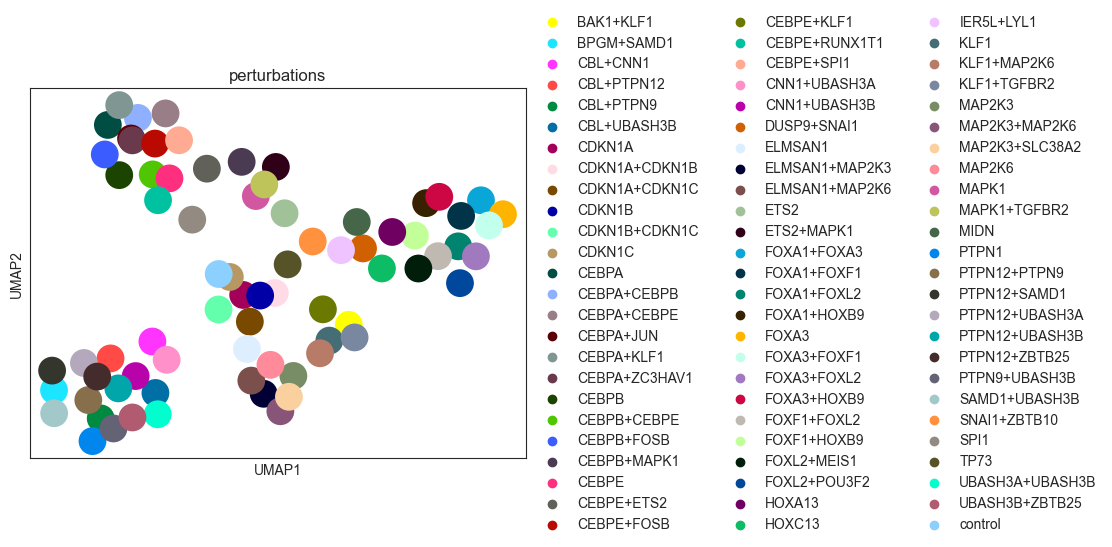

In [18]:
sc.pp.neighbors(psadata, use_rep='X')
sc.tl.umap(psadata)
sc.pl.umap(psadata, color='perturbations')

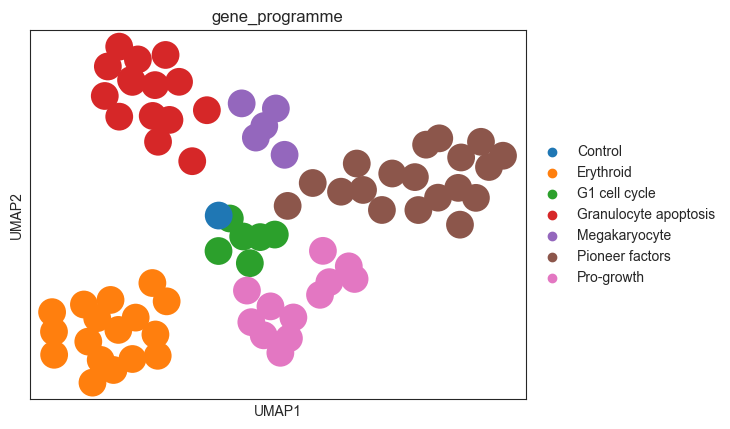

In [19]:
sc.pl.umap(psadata, color='gene_programme')

As we see based on the UMAP plot above, the perturbations are grouped into clusters that correspond to the gene programmes. Importantly, the classifier was not trained to separate the gene programmes, but the individual perturbations. Hence, the fact that the gene programmes are nicely separated in the embedding space indicates that the Discriminator Classifier works well, as the embeddings capture the effects of the perturbations on the cells.

Lastly, we can drop the one-hot encoded perturbations from the original AnnData object, as we are done with the training and the embeddings have been extracted.

In [23]:
adata.obs = adata.obs.drop("encoded_perturbations", axis=1)

### Centroid Space

The Centroid Space computes the centroids per perturbation of a pre-computed embedding. Hence, we first need to compute an embedding for the original dataset; here we use UMAP. Note that in this particular dataset, the UMAP is already computed. Nevertheless, we will compute it again to show how to use the Centroid Space in a general setting.

In [15]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

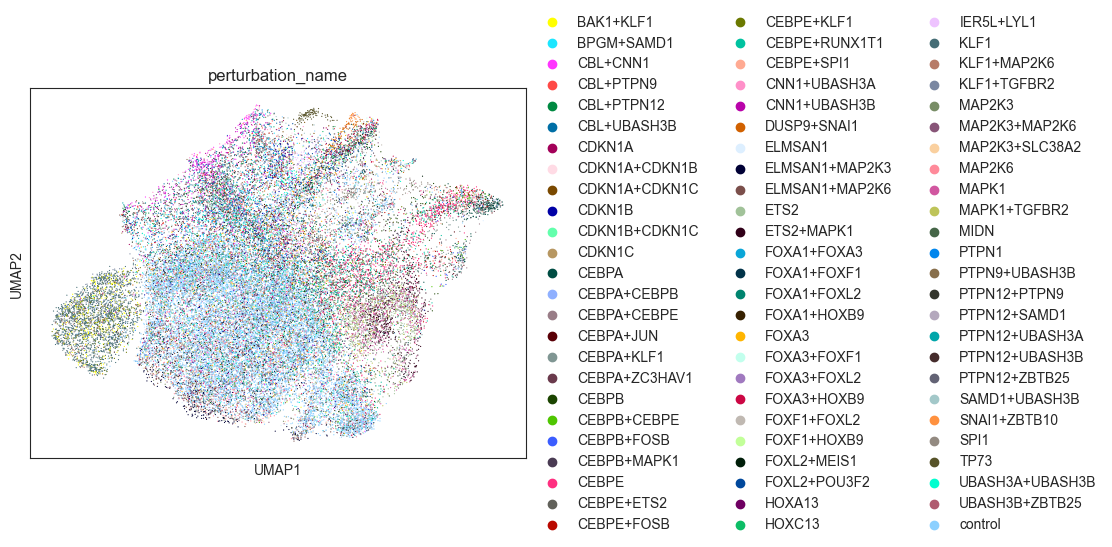

In [16]:
sc.pl.umap(adata, color="perturbation_name")

In [17]:
ps = pt.tl.CentroidSpace()
psadata = ps.compute(adata, target_col="perturbation_name", embedding_key="X_umap")

In [18]:
psadata

AnnData object with n_obs × n_vars = 75 × 2
    obs: 'perturbation_name', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guide_KLF1', 'guide_KMT2A', 'guide_LHX1', 'guide_LYL1', 'guide_MAML2', 'guide_MAP2K3', 'guid

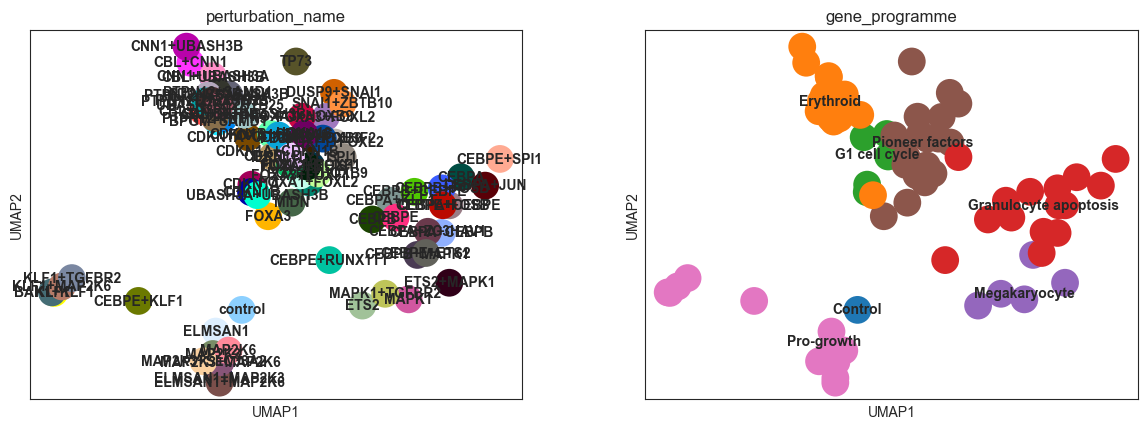

In [19]:
sc.pl.umap(psadata, color=["perturbation_name", "gene_programme"], legend_loc='on data')

Based on the UMAP plots above, we see that also the Centroid Space is capable of capturing the effects of the perturbations on the cells. The clusters align with the gene programmes, and the control perturbation is situated on the periphery of the 'Pro-growth' cluster.

## Cluster Spaces
### DBScan Space

DBSCAN clusters the given data using a density-based algorithm. Internally, pertpy uses the sklearn's implementation of DBSCAN, hence it is possible to pass any parameter accepted by sklearn's implementation. The most important parameters are `eps` and `min_samples`, which need to be tuned in accordance with the specific data.

You can cluster the data based on the full expression profile stored in .X or on a data representation with reduced dimensionality as specified by the `embedding_key` parameter. Be aware that computing the embedding on the .X matrix can be very time consuming for large datasets. In this tutorial, we will use the UMAP embedding, which was already calculated above but will be calculated again in the next cell for the purpose of completeness.

In [25]:
sc.tl.pca(adata, n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [26]:
ps = pt.tl.DBSCANSpace()

In [27]:
dbscan_psadata = ps.compute(adata, min_samples=50, eps=0.25, copy=True, embedding_key="X_umap", n_jobs=2)

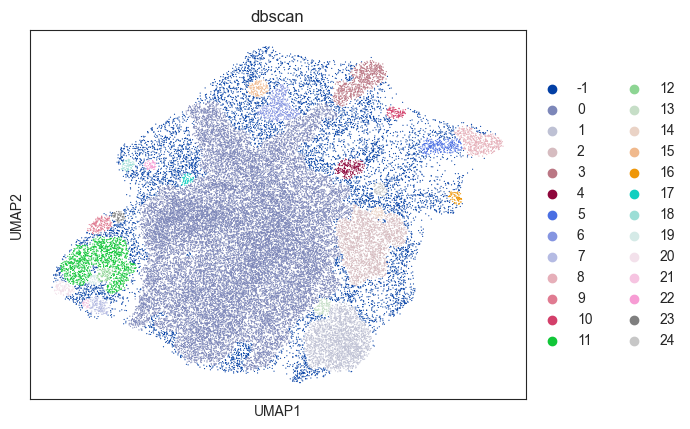

In [28]:
sc.pl.umap(dbscan_psadata, color="dbscan")

The UMAP plot above shows that several clusters have been identified based on density-based clustering. Of note, one could achieve a finer clustering using the whole data (adata.X) or a different embedding, which we omit here for the sake of simplicity.

Next, we want to evaluate if the identified clusters correspond to the gene programmes that we have defined for the individual perturbations above. Note that the `true_label_col` specifying the ground truth annotation in the `evaluate_clustering` method could also be something different from gene programs, or even the perturbation itself. As evaluation metics, we will calculate the NMI and ARI between the clusters and the gene programmes. Additionally, ASW can be calculated as well but, depending on the size of the dataset, it can take longer to compute.

In [29]:
dbscan_results = ps.evaluate_clustering(dbscan_psadata, true_label_col="gene_programme", cluster_col="dbscan",
                                        metric="l1", metrics=['nmi', 'ari'])

In [30]:
dbscan_results

{'nmi': 0.17569832707103, 'ari': 0.0918081441614236}

The NMI is a value between 0 and 1, where 1 would indicate that the computed clusters perfectly align with the ground truth clusters. Here, we have a value of approx. 0.18, which is comparably low and indicates that the DBSCAN clusters computed based on UMAP do not correspond well to the gene programmes.
The ARI takes a value between -0.5 and 1, where 0.0 indicates that the clusters are randomly assigned. Here, we see an ARI of 0.09, again highlighting that the density-based clustering based on UMAP does not align well with the gene programmes.
To improve the clustering, one could consider running DBSCAN on higher-dimensional data, e.g. by using a different embedding or no embedding at all.

### K-Means Space

Analogous to the steps used for DBSCAN clustering, we will now use K-means algorithm to cluster the data. This time, we will use the PCA embedding, which we calculated above. Internally, pertpy uses sklearn's implementation of K-means, hence it is possible to pass any parameter accepted by sklearn's implementation.

In [33]:
ps = pt.tl.KMeansSpace()
kmeans_psadata = ps.compute(adata, n_clusters=7, copy=True, embedding_key="X_pca")

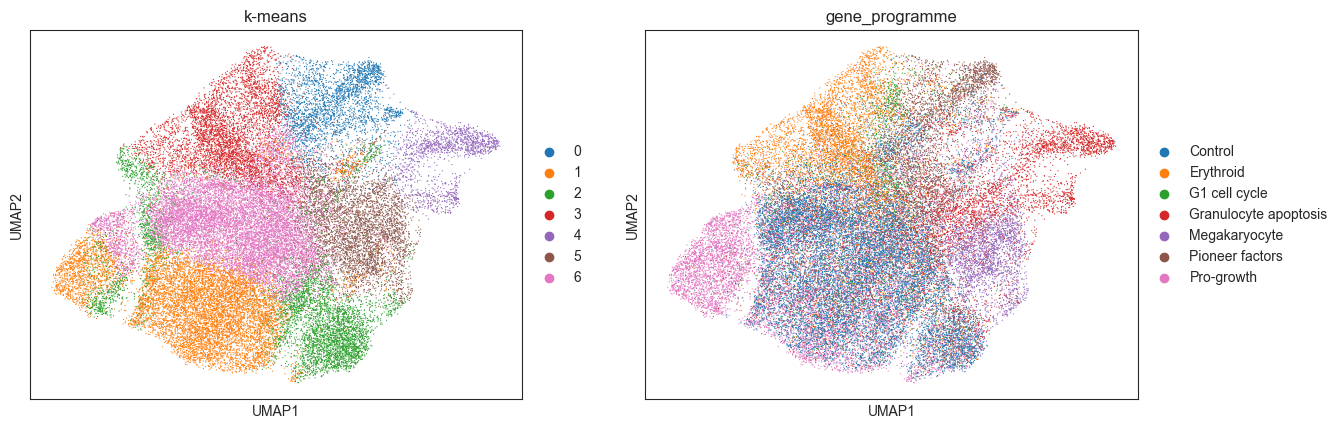

In [34]:
sc.pl.umap(kmeans_psadata, color=["k-means", "gene_programme"])

Again, we will evaluate the calculated clusters using the NMI and ARI metrics:

In [14]:
kmeans_results = ps.evaluate_clustering(kmeans_psadata, true_label_col="gene_programme", cluster_col="k-means",
                                        metric="l2", metrics=['nmi', 'ari'])

In [36]:
kmeans_results

{'nmi': 0.22118522241390073, 'ari': 0.15420778229072798}

Compared to the NMI and ARI computed for the DBSCAN clusters, both metrics are higher when using K-means on a PCA embedding. This could be due to the fact that the PCs capture more information than the 2D UMAP embedding, the ability to specify the number of target clusters when running K-means, or simply because K-Means is better suited for this data. Again, one could test using another embedding or no embedding at all, as well as additional parameters to improve the clustering.

## Conclusion

In this tutorial, we have introduced several methods to embed and work with data in the perturbation space. Whether first clustering the data or immediately embedding it in a perturbation space, the latter can be used to analyze the effects of perturbations on cells. One important application is the identification of perturbations with similar effects, similar to the gene programme annotation in this tutorial.
Furthermore, we showed how to arithmetically combine perturbations to create new perturbations, which can be used to validate experimental data or predict the effects of novel perturbations.